In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Load data
data_df = pd.read_csv('/content/drive/MyDrive/MMD6020_Final_Project/data/processed/chbmit_preprocessed_data.csv') 

# Separate X and y
X = data_df.drop(['Outcome'], axis=1)
y = data_df['Outcome']

# Split into train,validation and test
X_train, X_val_test, y_train, y_val_test = train_test_split(X,y,test_size=0.2, stratify=y, random_state=RANDOM_SEED)
X_val, X_test, y_val, y_test = train_test_split(X_val_test,y_val_test,test_size=0.5, stratify=y_val_test, random_state=RANDOM_SEED)

In [7]:
X_train.shape, X_val.shape, X_test.shape

((1677720, 23), (209715, 23), (209715, 23))

In [6]:
data_df.head()

,# FP1-F7,C3-P3,C4-P4,CZ-PZ,F3-C3,F4-C4,F7-T7,F8-T8,FP1-F3,FP2-F4,...,P3-O1,P4-O2,P7-O1,P7-T7,P8-O2,T7-FT9,T7-P7,T8-P8-0,T8-P8-1,Outcome
0,0.000020,0.000010,0.000022,0.000037,0.000032,0.000035,0.000016,0.000046,-0.000007,0.000043,...,0.000024,-0.000030,0.000010,-0.000011,-0.000037,0.000008,0.000012,0.000021,0.000021,0.0
1,0.000022,0.000008,0.000021,0.000039,0.000030,0.000032,0.000015,0.000039,-0.000006,0.000042,...,0.000026,-0.000017,0.000012,-0.000008,-0.000029,0.000010,0.000009,0.000023,0.000023,0.0
2,0.000021,0.000012,0.000021,0.000040,0.000025,0.000030,0.000013,0.000036,-0.000006,0.000040,...,0.000027,-0.000018,0.000014,-0.000009,-0.000034,0.000012,0.000009,0.000027,0.000027,0.0
3,0.000019,0.000012,0.000021,0.000039,0.000023,0.000028,0.000013,0.000035,-0.000008,0.000036,...,0.000030,-0.000024,0.000015,-0.000009,-0.000042,0.000009,0.000010,0.000033,0.000033,0.0
4,0.000019,0.000012,0.000021,0.000036,0.000023,0.000024,0.000012,0.000024,-0.000009,0.000032,...,0.000032,-0.000014,0.000017,-0.000008,-0.000031,0.000009,0.000008,0.000035,0.000035,0.0


# Visualization 

Text(0.5, 1.0, 'FP1-F7')

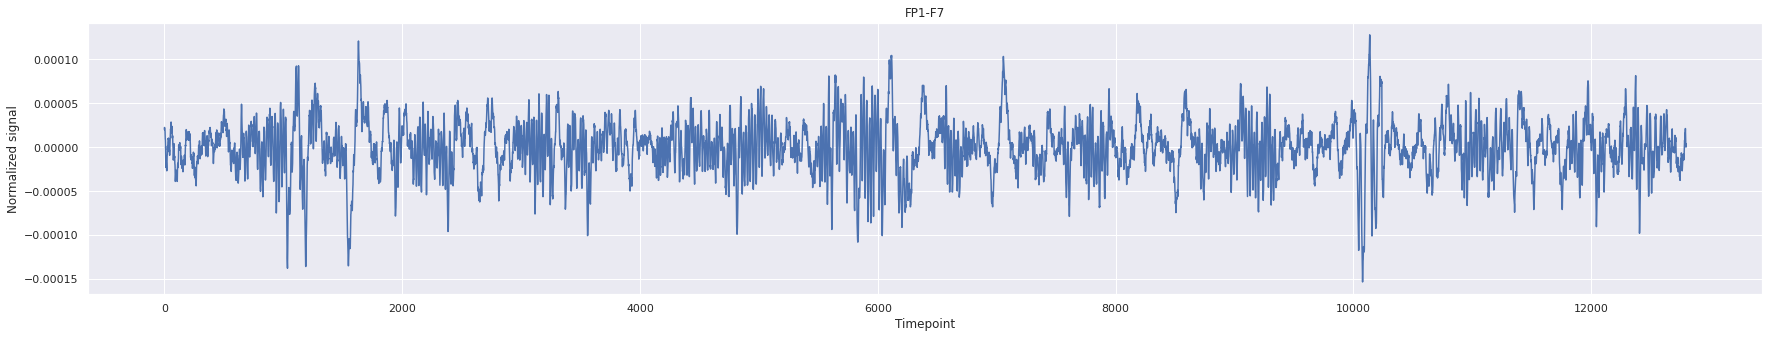

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

timepoints = list(data_df.index)

# Plot time series
sec = 50
plt.figure(figsize=(30, 5))
sns.lineplot(data=data_df[:256*sec], x=timepoints[:256*sec], y=data_df.iloc[:256*sec,0])
plt.xlabel('Timepoint')
plt.ylabel('Normalized signal')
plt.title('FP1-F7')

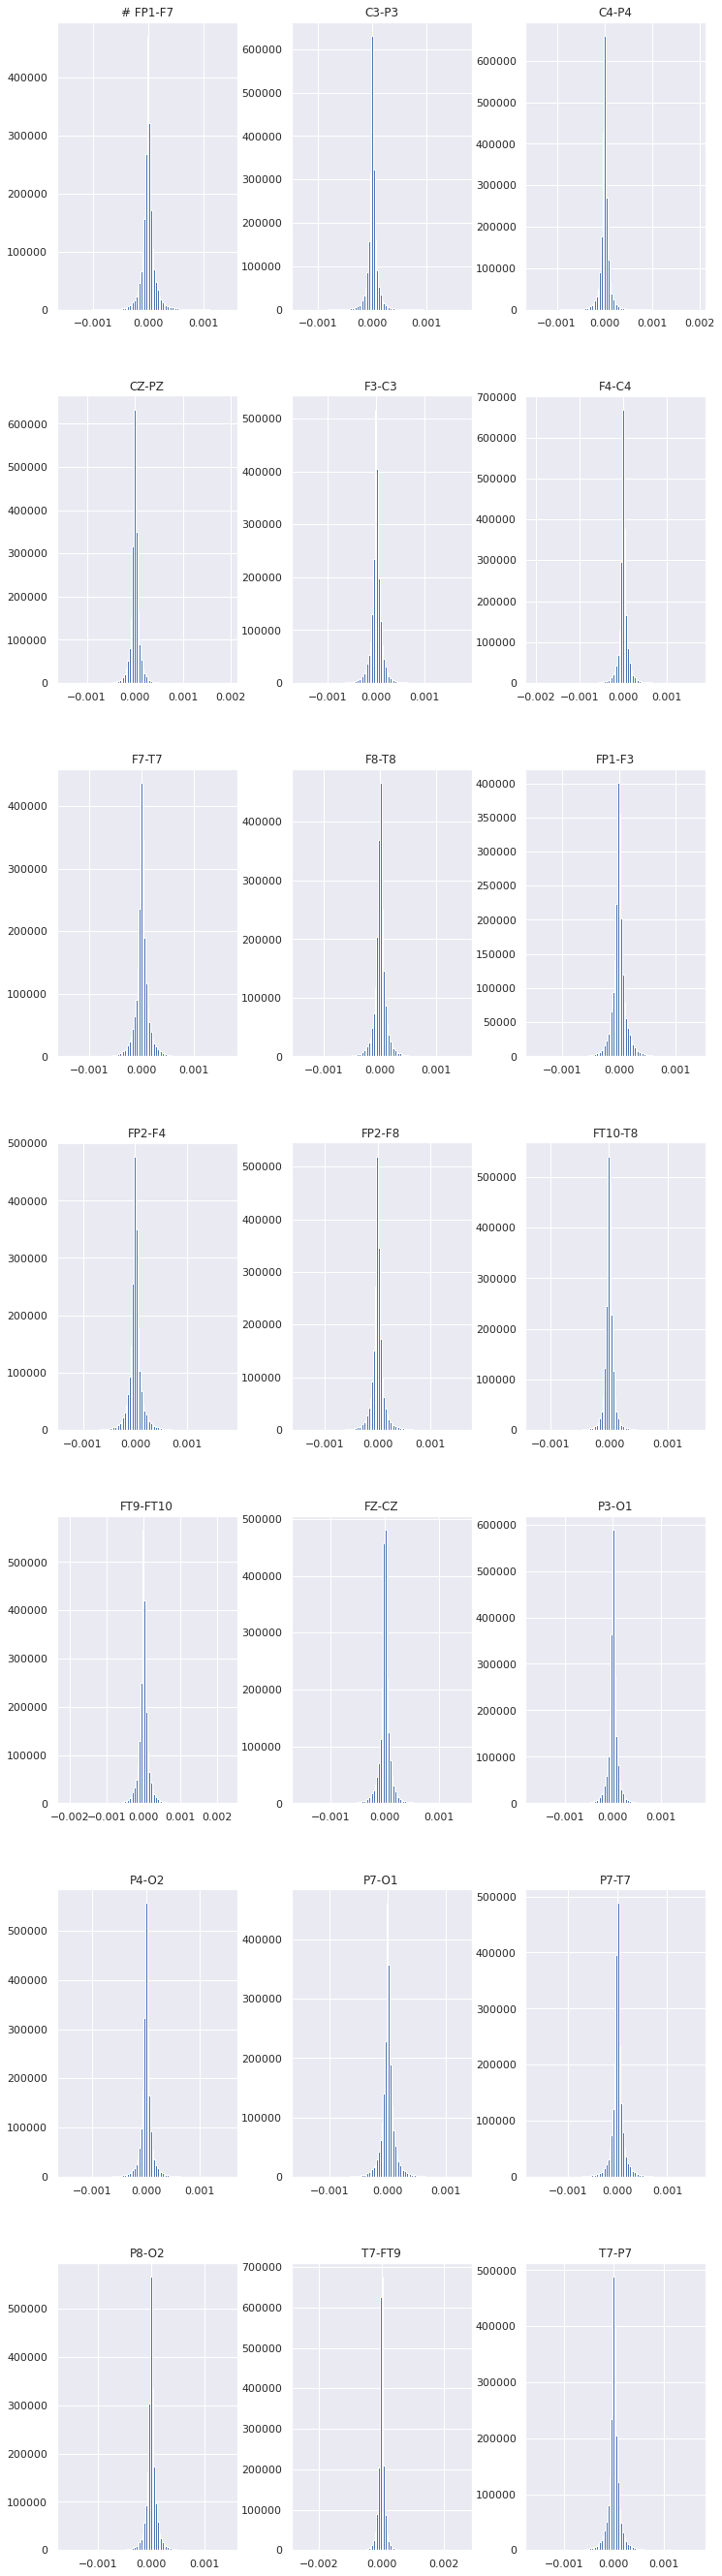

In [ ]:
# Visualize data distribution for each channel

fig, axes = plt.subplots(len(X.columns)//3, 3, figsize=(12, 48))

i = 0
for triaxis in axes:
    for axis in triaxis:
        X.hist(column = X.columns[i], bins = 100, ax=axis)
        i = i+1

# Feature Selection Exploration

## PCA

Cumulative explained variance with 12 components: 0.9009654177419512


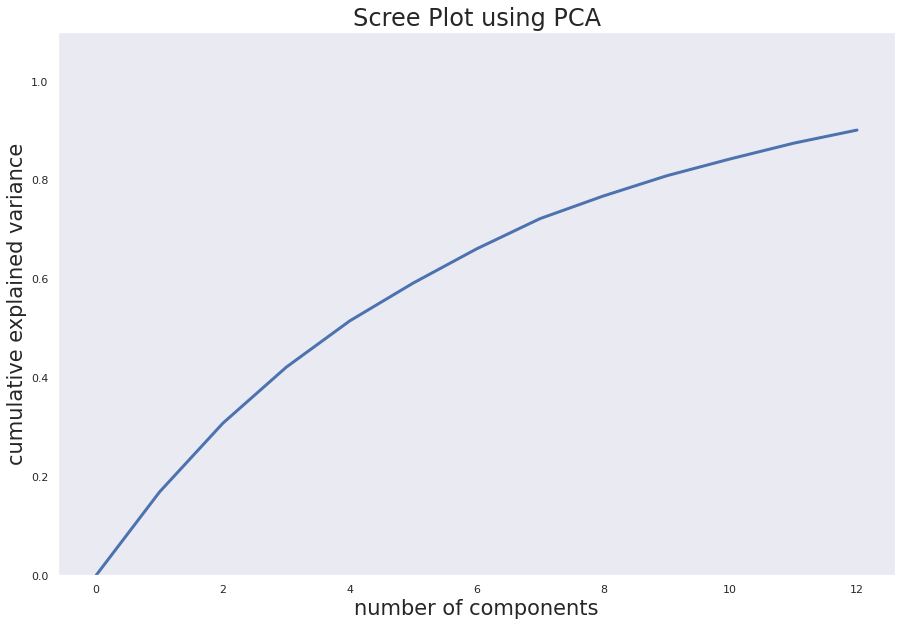

In [ ]:
from sklearn.decomposition import PCA

n_components = 12
pca = PCA(n_components=n_components)
pca.fit(X_train)

X_train_PCA = pca.transform(X_train)
X_val_PCA = pca.transform(X_val)

X_train_PCA = pd.DataFrame(data = X_train_PCA, columns = [f'PC{i}' for i in range(1, n_components+1)])
X_val_PCA = pd.DataFrame(data = X_val_PCA, columns = [f'PC{i}' for i in range(1, n_components+1)])
cev = np.cumsum(pca.explained_variance_ratio_)
cev = np.insert(cev, 0, 0)
print(f'Cumulative explained variance with {n_components} components: {cev[-1]}')
plt.figure(figsize=(15,10))
plt.ylim(0.0,1.1)
plt.plot(cev, linewidth=3)
plt.xlabel('number of components', fontsize=21)
plt.ylabel('cumulative explained variance', fontsize=21)
plt.title('Scree Plot using PCA', fontsize=24)
plt.rc('font', size=16)
plt.grid()
plt.show()

## SelectKBest

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=12)
selector.fit(X_train, y_train)

print(selector.scores_)

#Selected feature names
print(X_train.columns[selector.scores_.argsort()[::-1][:12]])

[0.03334895 0.9200989  7.24232753 4.84118146 0.01759939 1.8910065
 0.73219292 0.7474199  2.61002367 0.38992503 1.49069493 0.26643344
 0.46975964 1.52784631 2.02436665 0.01210043 0.65674814 0.39363759
 0.49836203 1.34355034 0.39384188 1.47414648 1.47414648]
Index(['C4-P4', 'CZ-PZ', 'FP1-F3', 'P3-O1', 'F4-C4', 'FZ-CZ', 'FP2-F8',
       'T8-P8-0', 'T8-P8-1', 'T7-FT9', 'C3-P3', 'F8-T8'],
      dtype='object')


## Recursive Feature Elimination (RFE)

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=250)
rfe = RFE(model, n_features_to_select=12)
selector = rfe.fit(X_train, y_train)

print("Num Features: ", selector .n_features_)
print("Selected Features Mask: ", selector .support_)
print("Feature Ranking: ", selector .ranking_)

#Selected feature names
print('Selected feature names: ', X_train.columns[selector .support_])

Num Features:  12
Selected Features Mask:  [False False  True  True False  True  True  True  True False  True False
 False  True  True False False False False  True False  True  True]
Feature Ranking:  [10  4  1  1 11  1  1  1  1  5  1  9  2  1  1 12  3  7  8  1  6  1  1]
Selected feature names:  Index(['C4-P4', 'CZ-PZ', 'F4-C4', 'F7-T7', 'F8-T8', 'FP1-F3', 'FP2-F8',
       'FZ-CZ', 'P3-O1', 'T7-FT9', 'T8-P8-0', 'T8-P8-1'],
      dtype='object')


# Model Training


In [ ]:
def confidence_interval(y_true, y_pred, X):
  error = 1 - accuracy_score(y_true, y_pred)
  ci_lower = error - 1.96  * np.sqrt( (error * (1 - error)) / len(X))
  ci_upper = error + 1.96  * np.sqrt( (error * (1 - error)) / len(X))
  return ci_lower, ci_upper

In [5]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
import numpy as np

# Define metrics
def evaluate(y_true, y_proba):
    y_pred = np.round(y_proba)
    return {
        'Precision': precision_score(y_true, y_pred, average='macro'),
        'Recall': recall_score(y_true, y_pred, average='macro'),
        'Macro f1': f1_score(y_true, y_pred, average='macro'),
        'Accuracy': accuracy_score(y_true, y_pred),
        'ROC AUC': roc_auc_score(y_true, y_proba)
    }

## AdaBoost

### Baseline

In [25]:
from sklearn.ensemble import AdaBoostClassifier

# Baseline Model
clf_adaboost = AdaBoostClassifier(random_state=RANDOM_SEED)
clf_adaboost.fit(X_train, y_train)

y_pred_train = clf_adaboost.predict_proba(X_train)[::,1]
train_metrics = evaluate(y_train, y_pred_train)
print('On training data: ', train_metrics)

y_pred_val = clf_adaboost.predict_proba(X_val)[::,1]
val_metrics = evaluate(y_val, y_pred_val)
print('On validation data: ', val_metrics)

On training data:  {'Precision': 0.78808356707228, 'Recall': 0.7862146246095892, 'Macro f1': 0.7858673281226809, 'Accuracy': 0.7862146246095892, 'ROC AUC': 0.8705158106948628}
On validation data:  {'Precision': 0.7871381572550014, 'Recall': 0.7853708090904655, 'Macro f1': 0.7850398899742124, 'Accuracy': 0.7853706220346661, 'ROC AUC': 0.8699930372390717}


### With PCA (n_components=12)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

n_components = 12
selector = PCA(n_components=n_components)
clf_adaboost = AdaBoostClassifier(random_state=RANDOM_SEED)

steps = [('selector', selector), ("clf_adaboost", clf_adaboost)]
pipe_adaboost = Pipeline(steps=steps)
pipe_adaboost.fit(X_train, y_train)


y_pred_train = pipe_adaboost.predict(X_train)
train_metrics = evaluate(y_train, y_pred_train)
print('On training data: ', train_metrics)

y_pred_val = pipe_adaboost.predict(X_val)
val_metrics = evaluate(y_val, y_pred_val)
print('On validation data: ', val_metrics)

On training data:  {'Precision': 0.747630512799748, 'Recall': 0.5869811410724078, 'Macro f1': 0.5070276471936794, 'Accuracy': 0.5869811410724078, 'ROC AUC': 0.5869811410724078}
On validation data:  {'Precision': 0.7479356243338144, 'Recall': 0.587155914644693, 'Macro f1': 0.5072751798196719, 'Accuracy': 0.5871539947071025, 'ROC AUC': 0.587155914644693}


### With SelectKBest (k=12)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline

selector = SelectKBest(score_func=f_classif, k=12)
clf_adaboost = AdaBoostClassifier(random_state=RANDOM_SEED)

steps = [('selector', selector), ("clf_adaboost", clf_adaboost)]
pipe_adaboost = Pipeline(steps=steps)
pipe_adaboost.fit(X_train, y_train)


y_pred_train = pipe_adaboost.predict(X_train)
train_metrics = evaluate(y_train, y_pred_train)
print('On training data: ', train_metrics)

y_pred_val = pipe_adaboost.predict(X_val)
val_metrics = evaluate(y_val, y_pred_val)
print('On validation data: ', val_metrics)

On training data:  {'Precision': 0.7698369047291311, 'Recall': 0.7681490355959278, 'Macro f1': 0.7677859023468668, 'Accuracy': 0.7681490355959278, 'ROC AUC': 0.7681490355959278}
On validation data:  {'Precision': 0.7696639349384515, 'Recall': 0.7679757745612397, 'Macro f1': 0.7676119285983036, 'Accuracy': 0.7679755859142169, 'ROC AUC': 0.7679757745612397}


### With Recursive Feature Elimination (RFE)

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

model = LogisticRegression(max_iter=250)
rfe = RFE(model, n_features_to_select=12)
selector = rfe.fit(X_train, y_train)
clf_adaboost = AdaBoostClassifier(random_state=RANDOM_SEED)

steps = [('selector', selector), ("clf_adaboost", clf_adaboost)]
pipe_adaboost = Pipeline(steps=steps)
pipe_adaboost.fit(X_train, y_train)


y_pred_train = pipe_adaboost.predict(X_train)
train_metrics = evaluate(y_train, y_pred_train)
print('On training data: ', train_metrics)

y_pred_val = pipe_adaboost.predict(X_val)
val_metrics = evaluate(y_val, y_pred_val)
print('On validation data: ', val_metrics)

On training data:  {'Precision': 0.7707360029278956, 'Recall': 0.7691939060153065, 'Macro f1': 0.7688647727300129, 'Accuracy': 0.7691939060153065, 'ROC AUC': 0.7691939060153065}
On validation data:  {'Precision': 0.7705568500674509, 'Recall': 0.769053416652576, 'Macro f1': 0.7687320018517123, 'Accuracy': 0.769053238919486, 'ROC AUC': 0.769053416652576}


### HP Tuning (very very slow, did not perform)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

tuned_parameters = {
  "n_estimators": np.linspace(20, 100, num=11),
  "learning_rate": np.linspace(0.1, 1, num=10),
  }

cv = StratifiedKFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)

random_search = RandomizedSearchCV(
    AdaBoostClassifier(random_state=RANDOM_SEED), 
    tuned_parameters, 
    n_iter=150, 
    scoring='accuracy', 
    cv=cv,
)
random_search.fit(X_train, y_train);
print('Finished!')

In [ ]:
print("Meilleur ensemble de paramètres trouvé")
print()
print(random_search.best_params_)
print(random_search.best_score_)

In [ ]:
# Use "gpu_hist" for training the model.
adaboost_HP =  AdaBoostClassifier(n_estimators=random_search.best_params_["n_estimators"],
                                  learning_rate=random_search.best_params_["learning_rate"],
                                  random_state=RANDOM_SEED)

# Fit the model using predictor X and response y.
adaboost_HP.fit(X_train, y_train)

y_pred_train = adaboost_HP.predict(X_train)
train_metrics = evaluate(y_train, y_pred_train)
print('On training data: ', train_metrics)

y_pred_val = adaboost_HP.predict(X_val)
test_metrics = evaluate(y_val, y_pred_val)
print('On validation data: ', test_metrics)

## Logistic Regression

### Baseline

In [26]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression

# Baseline Model
clf_logreg = LogisticRegression(random_state=RANDOM_SEED)
clf_logreg.fit(X_train, y_train)

y_pred_train = clf_logreg.predict_proba(X_train)[::,1]
train_metrics = evaluate(y_train, y_pred_train)
print('On training data: ', train_metrics)

y_pred_val = clf_logreg.predict_proba(X_val)[::,1]
val_metrics = evaluate(y_val, y_pred_val)
print('On validation data: ', val_metrics)

On training data:  {'Precision': 0.5062072651919522, 'Recall': 0.5062066375795723, 'Macro f1': 0.5061941554859379, 'Accuracy': 0.5062066375795723, 'ROC AUC': 0.5034873442091508}
On validation data:  {'Precision': 0.5060017171597719, 'Recall': 0.5060010269273423, 'Macro f1': 0.5059868103858747, 'Accuracy': 0.5060010013589872, 'ROC AUC': 0.502408334513076}


### With PCA (n_components=12)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

n_components = 12
selector = PCA(n_components=n_components)
clf_logreg = LogisticRegression(random_state=RANDOM_SEED)

steps = [('selector', selector), ("clf_logreg", clf_logreg)]
pipe_logreg = Pipeline(steps=steps)
pipe_logreg.fit(X_train, y_train)


y_pred_train = pipe_logreg.predict(X_train)
train_metrics = evaluate(y_train, y_pred_train)
print('On training data: ', train_metrics)

y_pred_val = pipe_logreg.predict(X_val)
val_metrics = evaluate(y_val, y_pred_val)
print('On validation data: ', val_metrics)

On training data:  {'Precision': 0.506432550087514, 'Recall': 0.5064319433516915, 'Macro f1': 0.5064203044029669, 'Accuracy': 0.5064319433516916, 'ROC AUC': 0.5064319433516915}
On validation data:  {'Precision': 0.5062401633889579, 'Recall': 0.5062394457338231, 'Macro f1': 0.5062252360413415, 'Accuracy': 0.5062394201654626, 'ROC AUC': 0.5062394457338232}


### With SelectKBest (k=12)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline

selector = SelectKBest(score_func=f_classif, k=12)
clf_logreg = LogisticRegression(random_state=RANDOM_SEED)
steps = [('selector', selector), ("clf_logreg", clf_logreg)]
pipe_logreg = Pipeline(steps=steps)
pipe_logreg.fit(X_train, y_train)


y_pred_train = pipe_logreg.predict(X_train)
train_metrics = evaluate(y_train, y_pred_train)
print('On training data: ', train_metrics)

y_pred_val = pipe_logreg.predict(X_val)
val_metrics = evaluate(y_val, y_pred_val)
print('On validation data: ', val_metrics)

On training data:  {'Precision': 0.5064103903502273, 'Recall': 0.5064098896120925, 'Macro f1': 0.506400250409003, 'Accuracy': 0.5064098896120927, 'ROC AUC': 0.5064098896120925}
On validation data:  {'Precision': 0.5054150553082916, 'Recall': 0.5054145149126186, 'Macro f1': 0.5054021632664916, 'Accuracy': 0.5054144910950575, 'ROC AUC': 0.5054145149126187}


### With Recursive Feature Elimination (RFE)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE


model = LogisticRegression(max_iter=250)
rfe = RFE(model, n_features_to_select=12)
selector = rfe.fit(X_train, y_train)
clf_logreg = LogisticRegression(random_state=RANDOM_SEED)
steps = [('selector', selector), ("clf_logreg", clf_logreg)]
pipe_logreg = Pipeline(steps=steps)
pipe_logreg.fit(X_train, y_train)


y_pred_train = pipe_logreg.predict(X_train)
train_metrics = evaluate(y_train, y_pred_train)
print('On training data: ', train_metrics)

y_pred_val = pipe_logreg.predict(X_val)
val_metrics = evaluate(y_val, y_pred_val)
print('On validation data: ', val_metrics)

On training data:  {'Precision': 0.506296631569839, 'Recall': 0.5062960446320006, 'Macro f1': 0.5062845392627384, 'Accuracy': 0.5062960446320006, 'ROC AUC': 0.5062960446320006}
On validation data:  {'Precision': 0.5060016583937952, 'Recall': 0.5060010258359465, 'Macro f1': 0.5059879965776427, 'Accuracy': 0.5060010013589872, 'ROC AUC': 0.5060010258359465}


### HP Tuning (very very slow, did not perform)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
import numpy as np

tuned_parameters = {
  "penalty": ["l1", "l2", "elasticnet", "none"],
  "C": [0.01, 0.05, 0.1, 0.5, 0.7, 1.0, 5, 10, 20, 50, 70, 100],
  "max_iter": np.linspace(100, 1000, num=11),
  }

cv = StratifiedKFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)

random_search = RandomizedSearchCV(
    LogisticRegression(solver='saga', class_weight=None, random_state=RANDOM_SEED), 
    tuned_parameters, 
    n_iter=2, 
    scoring='accuracy', 
    cv=cv,
)
random_search.fit(X_train, y_train);
print('Finished!')

In [ ]:
print("Meilleur ensemble de paramètres trouvé")
print()
print(random_search.best_params_)
print(random_search.best_score_)

In [ ]:
logreg_HP = LogisticRegression(penalty = random_search.best_params_['penalty'],
                               C = random_search.best_params_['C'],
                               max_iter = random_search.best_params_['max_iter'],
                               solver='saga', 
                               class_weight=None, 
                               random_state=RANDOM_SEED)
                               
# Fit the model using predictor X and response y.
logreg_HP.fit(X_train, y_train)

y_pred_train = logreg_HP.predict(X_train)
train_metrics = evaluate(y_train, y_pred_train)
print('On training data: ', train_metrics)

y_pred_val = logreg_HP.predict(X_val)
test_metrics = evaluate(y_val, y_pred_val)
print('On validation data: ', test_metrics)

## Random Forest

In [27]:
from sklearn.ensemble import RandomForestClassifier

# Baseline Model
clf_rf = RandomForestClassifier(random_state=RANDOM_SEED)
clf_rf.fit(X_train, y_train)

y_pred_train = clf_rf.predict_proba(X_train)[::,1]
train_metrics = evaluate(y_train, y_pred_train)
print('On training data: ', train_metrics)

y_pred_val = clf_rf.predict_proba(X_val)[::,1]
val_metrics = evaluate(y_val, y_pred_val)
print('On validation data: ', val_metrics)

On training data:  {'Precision': 0.9999612589397114, 'Recall': 0.9999612569439478, 'Macro f1': 0.999961256943909, 'Accuracy': 0.9999612569439478, 'ROC AUC': 0.9999818324661987}
On validation data:  {'Precision': 0.9086473847354466, 'Recall': 0.9082183735188443, 'Macro f1': 0.908194208179205, 'Accuracy': 0.9082182962592089, 'ROC AUC': 0.9677803891516356}


## XGBoost

In [6]:
import xgboost as xgb

# Use "gpu_hist" for training the model.
clf_xgb = xgb.XGBClassifier(tree_method="gpu_hist")
# Fit the model using predictor X and response y.
clf_xgb.fit(X_train, y_train)

# Baseline model
y_pred_train = clf_xgb.predict_proba(X_train)[::,1]
train_metrics = evaluate(y_train, y_pred_train)
print('On training data: ', train_metrics)

y_pred_val = clf_xgb.predict_proba(X_val)[::,1]
val_metrics = evaluate(y_val, y_pred_val)
print('On validation data: ', val_metrics)

On training data:  {'Precision': 0.8045007153764576, 'Recall': 0.8032687218367784, 'Macro f1': 0.8030695293099595, 'Accuracy': 0.8032687218367784, 'ROC AUC': 0.8883569171877101}
On validation data:  {'Precision': 0.803412671860127, 'Recall': 0.8021840679895603, 'Macro f1': 0.8019834900696409, 'Accuracy': 0.8021839162673151, 'ROC AUC': 0.8877875325622029}


In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

tuned_parameters = {
  'gamma': np.linspace(0, 2, num=50),
  'max_depth': np.linspace(0, 12, num=13, dtype=int),
  'eta':np.linspace(0,1,num=11, dtype =int)
  }

cv = StratifiedKFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)

random_search = RandomizedSearchCV(
    xgb.XGBClassifier(tree_method="gpu_hist"), 
    tuned_parameters, 
    n_iter=150, 
    scoring='accuracy', 
    cv=cv,
)
random_search.fit(X_train, y_train);
print('Finished!')

In [ ]:
print("Meilleur ensemble de paramètres trouvé")
print()
print(random_search.best_params_)
print(random_search.best_score_)

In [7]:
import xgboost as xgb


xgb_HP = xgb.XGBClassifier(tree_method="gpu_hist", 
                           max_depth = 17, 
                           gamma = 0.4081632653061224, 
                           eta = 0.3157894736842105, 
                           reg_lambda = 4, 
                           reg_alpha = 2)
# Fit the model using predictor X and response y.
xgb_HP.fit(X_train, y_train)

y_pred_train = xgb_HP.predict_proba(X_train)[::,1]
train_metrics = evaluate(y_train, y_pred_train)
print('On training data: ', train_metrics)

y_pred_val = xgb_HP.predict_proba(X_val)[::,1]
val_metrics = evaluate(y_val, y_pred_val)
print('On validation data: ', val_metrics)

On training data:  {'Precision': 0.9193906369132965, 'Recall': 0.9163567222182485, 'Macro f1': 0.9162051771418556, 'Accuracy': 0.9163567222182486, 'ROC AUC': 0.9667138193694397}
On validation data:  {'Precision': 0.8831793495334537, 'Recall': 0.8818016354718808, 'Macro f1': 0.8816951687208658, 'Accuracy': 0.8818014925017286, 'ROC AUC': 0.949690814439949}


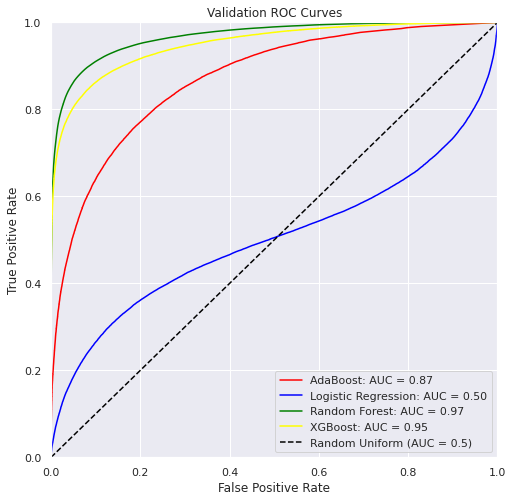

In [17]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

colors = ['red', 'blue', 'green', 'yellow', 'orange']

def plot_ROC(classifiers_tuple, subset, add_random=True):

    plt.figure(figsize=(8, 8))

    for count, classifier in enumerate(classifiers_tuple):

        
        clf = classifier[0]
        clf_name = classifier[1]
        X = classifier[2]
        y = classifier[3]

        y_pred = clf.predict_proba(X)[::,1]
        fpr, tpr, _ = roc_curve(y, y_pred)
        roc_auc = roc_auc_score(y, y_pred)

        plt.plot(fpr, tpr, color=colors[count], label=f"{clf_name}: AUC = %0.2f" % roc_auc)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"{subset} ROC Curves")

    if add_random:
        plt.plot([0, 1], [0, 1], color="black", label='Random Uniform (AUC = 0.5)', linestyle="--")
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.legend(loc="lower right")

classifiers = [(clf_adaboost, 'AdaBoost', X_val, y_val),
               (clf_logreg, 'Logistic Regression', X_val, y_val),
               (clf_rf, 'Random Forest', X_val, y_val),
               (xgb_HP, 'XGBoost', X_val, y_val)
               ]
plot_ROC(classifiers, "Validation", add_random=True)

# Save models

In [10]:
import pickle
import os

model_dir = '/content/drive/MyDrive/MMD6020_Final_Project/models'

In [9]:
adaboost_filename = os.path.join(model_dir, 'adaboost.pkl')
with open(adaboost_filename, 'wb') as file:
  pickle.dump(clf_adaboost, file)

In [10]:
logreg_filename = os.path.join(model_dir, 'logreg.pkl')
with open(logreg_filename, 'wb') as file:
  pickle.dump(clf_logreg, file)

In [11]:
rf_filename = os.path.join(model_dir, 'randomforest.pkl')
with open(rf_filename, 'wb') as file:
  pickle.dump(clf_rf, file)

In [11]:
xgb_filename = os.path.join(model_dir, 'xgboost.pkl')
with open(xgb_filename, 'wb') as file:
  pickle.dump(xgb_HP, file)

# Load models

In [12]:
import pickle
import os

model_dir = '/content/drive/MyDrive/MMD6020_Final_Project/models'

In [13]:
adaboost_filename = os.path.join(model_dir, 'adaboost.pkl')
clf_adaboost = pickle.load(open(adaboost_filename, 'rb'))

In [14]:
logreg_filename = os.path.join(model_dir, 'logreg.pkl')
clf_logreg = pickle.load(open(logreg_filename, 'rb'))

In [15]:
rf_filename = os.path.join(model_dir, 'randomforest.pkl')
clf_rf = pickle.load(open(rf_filename, 'rb'))

In [16]:
xgb_filename = os.path.join(model_dir, 'xgboost.pkl')
xgb_HP = pickle.load(open(xgb_filename, 'rb'))

# Evaluate on test set

## Metrics

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
import numpy as np

# Define metrics
def evaluate(y_true, y_proba):
    y_pred = np.round(y_proba)
    return {
        'Precision': precision_score(y_true, y_pred, average='macro'),
        'Recall': recall_score(y_true, y_pred, average='macro'),
        'Macro f1': f1_score(y_true, y_pred, average='macro'),
        'Accuracy': accuracy_score(y_true, y_pred),
        'ROC AUC': roc_auc_score(y_true, y_proba)
    }

### Adaboost

On test data:  {'Precision': 0.7868967386998242, 'Recall': 0.7849269655071056, 'Macro f1': 0.7845573243673246, 'Accuracy': 0.7849271630546217, 'ROC AUC': 0.8694153039568022}


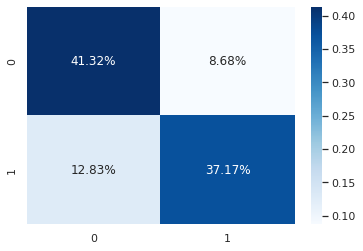

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred_test = clf_adaboost.predict_proba(X_test)[::,1]
test_metrics = evaluate(y_test, y_pred_test)
print('On test data: ', test_metrics)
cf_matrix = confusion_matrix(y_test, np.round(y_pred_test))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

### Random Forest

On test data:  {'Precision': 0.908108056418331, 'Recall': 0.9077032365561926, 'Macro f1': 0.9076804107651182, 'Accuracy': 0.907703311637222, 'ROC AUC': 0.967480583519373}


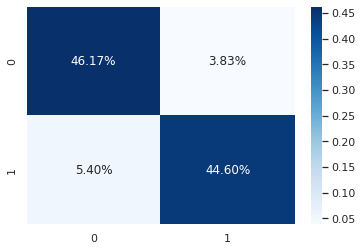

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred_test = clf_rf.predict_proba(X_test)[::,1]
test_metrics = evaluate(y_test, y_pred_test)
print('On test data: ', test_metrics)
cf_matrix = confusion_matrix(y_test, np.round(y_pred_test))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

### Logistic Regression

On test data:  {'Precision': 0.5026590627358323, 'Recall': 0.502658330117798, 'Macro f1': 0.5026240910746584, 'Accuracy': 0.5026583696922013, 'ROC AUC': 0.4990392699011681}


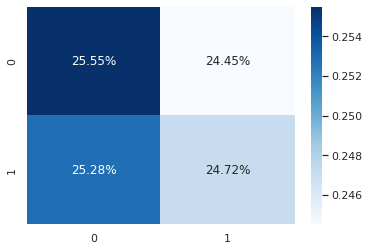

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred_test = clf_logreg.predict_proba(X_test)[::,1]
test_metrics = evaluate(y_test, y_pred_test)
print('On test data: ', test_metrics)
cf_matrix = confusion_matrix(y_test, np.round(y_pred_test))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

### XGBoost

On test data:  {'Precision': 0.8820153019225173, 'Recall': 0.8805901793517387, 'Macro f1': 0.8804788380017539, 'Accuracy': 0.8805903249648332, 'ROC AUC': 0.9489779609555664}


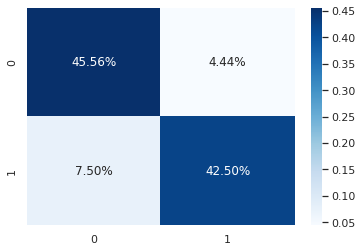

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred_test = xgb_HP.predict_proba(X_test)[::,1]
test_metrics = evaluate(y_test, y_pred_test)
print('On test data: ', test_metrics)
cf_matrix = confusion_matrix(y_test, np.round(y_pred_test))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

## Plot Calibration Curve

In [19]:
from sklearn.calibration import CalibrationDisplay
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
sns.set()

colors = ['red', 'blue', 'green', 'yellow', 'orange']

def plot_Calibration(classifiers_tuple, plot_name, add_random=False):
    calibration_displays = {}
    fig = plt.figure(figsize=(8, 8))
    gs = GridSpec(2, 2)
    ax_calibration_curve = fig.add_subplot(gs[:2, :2])
    nbins = 10

    for count, classifier in enumerate(classifiers_tuple):

        clf = classifier[0]
        clf_name = classifier[1]
        X = classifier[2]
        y = classifier[3]
        y_pred = clf.predict_proba(X)[:,1]
        
        display = CalibrationDisplay.from_predictions(y, y_pred, n_bins=nbins, name=clf_name, ax=ax_calibration_curve, color=colors[count])
        calibration_displays[clf_name] = display

    if add_random:
        y_random = np.random.uniform(low=0.0, high=1.0, size=len(y))
        CalibrationDisplay.from_predictions(y, y_random, n_bins=nbins, name='Random Uniform', ax=ax_calibration_curve, color='black')

    ax_calibration_curve.set_title("Calibration plots");
    plt.legend(loc="upper left")

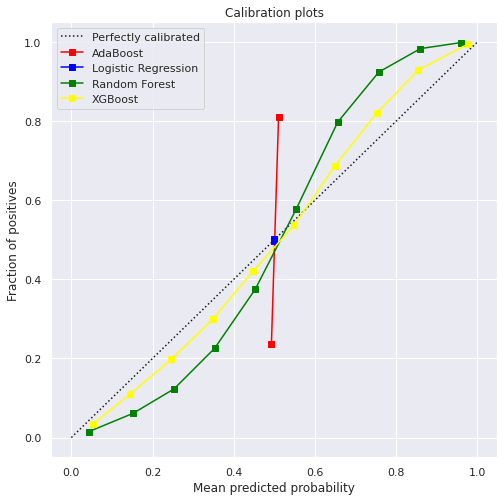

In [20]:
classifiers = [(clf_adaboost, 'AdaBoost', X_test, y_test),
               (clf_logreg, 'Logistic Regression', X_test, y_test),
               (clf_rf, 'Random Forest', X_test, y_test),
               (xgb_HP, 'XGBoost', X_test, y_test)
               ]
plot_Calibration(classifiers, plot_name='Testing')

## Plot ROC

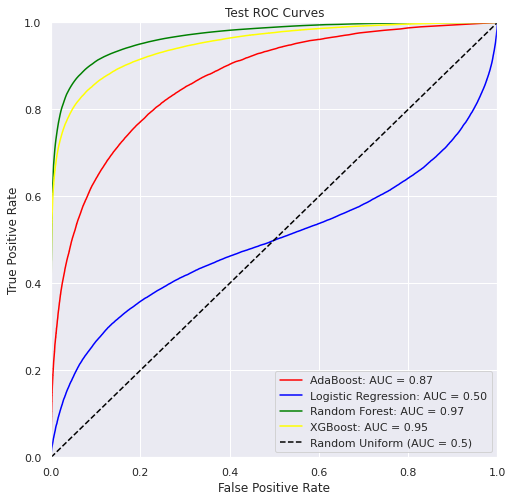

In [22]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

colors = ['red', 'blue', 'green', 'yellow', 'orange']

def plot_ROC(classifiers_tuple, subset, add_random=True):

    plt.figure(figsize=(8, 8))

    for count, classifier in enumerate(classifiers_tuple):

        
        clf = classifier[0]
        clf_name = classifier[1]
        X = classifier[2]
        y = classifier[3]

        y_pred = clf.predict_proba(X)[::,1]
        fpr, tpr, _ = roc_curve(y, y_pred)
        roc_auc = roc_auc_score(y, y_pred)

        plt.plot(fpr, tpr, color=colors[count], label=f"{clf_name}: AUC = %0.2f" % roc_auc)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"{subset} ROC Curves")

    if add_random:
        plt.plot([0, 1], [0, 1], color="black", label='Random Uniform (AUC = 0.5)', linestyle="--")
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.legend(loc="lower right")

classifiers = [(clf_adaboost, 'AdaBoost', X_test, y_test),
               (clf_logreg, 'Logistic Regression', X_test, y_test),
               (clf_rf, 'Random Forest', X_test, y_test),
               (xgb_HP, 'XGBoost', X_test, y_test)
               ]
plot_ROC(classifiers, "Test", add_random=True)